<a href="https://colab.research.google.com/github/blakeobeans/kaggle_notebooks/blob/master/Titanic_w_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt

### Mount Google Drive

In [432]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [433]:
#set wd
path = '/content/drive/My Drive/Colab Notebooks/Kaggle/Titanic'
os.chdir(path)
path

'/content/drive/My Drive/Colab Notebooks/Kaggle/Titanic'

In [0]:
from google.colab import files

### Set API Creds

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "blakeobeans"

In [0]:
os.environ['KAGGLE_KEY'] = "60017706bdc00c3f8b75bdd75f4331b0"

### Download Data

In [437]:
!kaggle competitions download -c titanic

test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


### Import

In [0]:
import pandas as pd

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [440]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [441]:
train.shape

(891, 12)

In [442]:
test.shape

(418, 11)

### Missing Data

### Feature Selection

#### Remove irrelevant variables

In [0]:
train = train[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
test = test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

### Missing Data Imputation

In [0]:
import missingno as msno

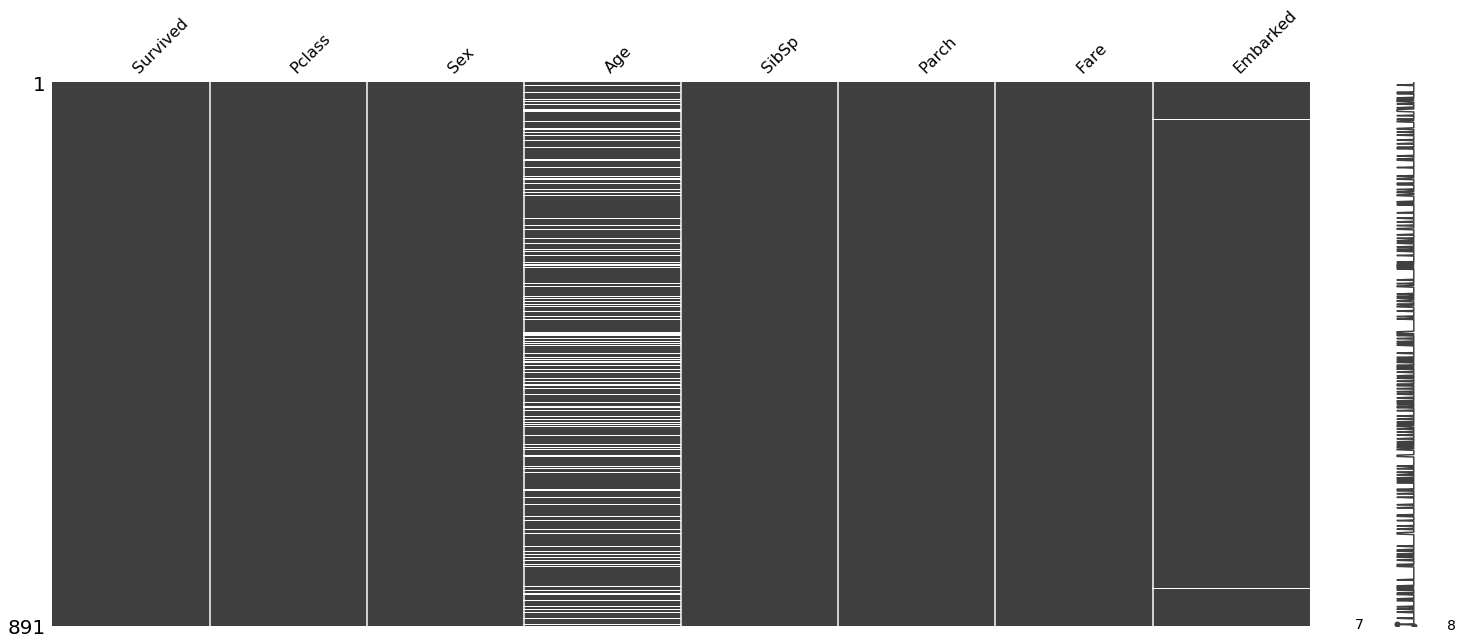

In [445]:
msno.matrix(train)

We're missing data for the "age" variable- one quantitative variable. We'll impute based on the most frequent value. This can be improved by looking at correlations between age and other variables in the dataset.

In [0]:
from sklearn import preprocessing
import numpy as np

In [0]:
#impute missing data for "Embarked"
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')

In [0]:
train_imputed = my_imputer.fit_transform(train)
test_imputed = my_imputer.fit_transform(test)

In [0]:
#convert imputed array into pandas df with column names
train_imputed = pd.DataFrame(train_imputed, columns = train.columns)
test_imputed = pd.DataFrame(test_imputed, columns = test.columns)

#### Categorical Encoding

Because the XGBoost algorithm requires numeric value, we have to main options for dealing with categorical variables: **label encoding** and **one-hot encoding**.  
I'll opt for label encoding where there is an inherent rank and one-hot encoding otherwise.

In [450]:
train_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null object
Pclass      891 non-null object
Sex         891 non-null object
Age         891 non-null object
SibSp       891 non-null object
Parch       891 non-null object
Fare        891 non-null object
Embarked    891 non-null object
dtypes: object(8)
memory usage: 55.8+ KB


**Label encoding**: Pclass  
**One-hot encoding**: Sex, Embarked

In [0]:
train_imputed_cat_ohe = train_imputed[['Sex', 'Embarked']]
train_imputed_cat_le = train_imputed[['Pclass']]
train_imputed_quant = train_imputed[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']]

In [0]:
test_imputed_cat_ohe = test_imputed[['Sex', 'Embarked']]
test_imputed_cat_le = test_imputed[['Pclass']]
test_imputed_quant = test_imputed[['Age', 'SibSp', 'Parch', 'Fare']]

#### Label Encoding

Label encoding can be done with pandas

In [453]:
train_imputed_cat_le.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
Pclass    891 non-null object
dtypes: object(1)
memory usage: 7.1+ KB


In [454]:
train_imputed_cat_le.head()

,Pclass
0,3
1,1
2,3
3,1
4,3


In [455]:
train_imputed_cat_le['Pclass'] = pd.to_numeric(train_imputed_cat_le['Pclass']) # Replace strings with an integer
test_imputed_cat_le['Pclass'] = pd.to_numeric(test_imputed_cat_le['Pclass']) # Replace strings with an integer

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### One-hot encoding

In [456]:
train_imputed_cat_ohe.Sex.unique()

array(['male', 'female'], dtype=object)

In [457]:
train_imputed_cat_ohe.Embarked.unique()

array(['S', 'C', 'Q'], dtype=object)

In [0]:
enc = preprocessing.OneHotEncoder()

In [0]:
enc.fit(train_imputed_cat_ohe)
onehotlabels = enc.transform(train_imputed_cat_ohe).toarray()
df = pd.DataFrame(onehotlabels)
train = pd.concat([train_imputed_quant, train_imputed_cat_le, df], axis=1, sort=False)

In [460]:
train.head()

,Survived,Age,SibSp,Parch,Fare,Pclass,0,1,2,3,4
0,0,22,1,0,7.25,3,0.0,1.0,0.0,0.0,1.0
1,1,38,1,0,71.2833,1,1.0,0.0,1.0,0.0,0.0
2,1,26,0,0,7.925,3,1.0,0.0,0.0,0.0,1.0
3,1,35,1,0,53.1,1,1.0,0.0,0.0,0.0,1.0
4,0,35,0,0,8.05,3,0.0,1.0,0.0,0.0,1.0


In [0]:
train.columns = ['Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'M', 'F', 'S', 'C', 'Q']

In [0]:
enc.fit(test_imputed_cat_ohe)
onehotlabels = enc.transform(test_imputed_cat_ohe).toarray()
df = pd.DataFrame(onehotlabels)
test = pd.concat([test_imputed_quant, test_imputed_cat_le, df], axis=1, sort=False)

In [0]:
test.columns = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'M', 'F', 'S', 'C', 'Q']

### Create Validation Dataset

Because this is a public dataset, the test data can be submitted multiple times. Therefore, a validation dataset is not necessary.

In [0]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.1, random_state=42)

In [0]:
train_label = train['Survived']
val_label = val['Survived']

In [0]:
train_features = train.drop('Survived', axis = 1)
val_features = val.drop('Survived', axis = 1)

In [0]:
train[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']] = train[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']].astype(float)
val[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']] = val[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']].astype(float)

In [0]:
test[['Age', 'SibSp', 'Parch', 'Fare']] = test[['Age', 'SibSp', 'Parch', 'Fare']].astype(float)

In [0]:
train_features[['Age', 'SibSp', 'Parch', 'Fare']] = train_features[['Age', 'SibSp', 'Parch', 'Fare']].astype(float)
val_features[['Age', 'SibSp', 'Parch', 'Fare']] = val_features[['Age', 'SibSp', 'Parch', 'Fare']].astype(float)
#val_features.dtypes

In [0]:
train_label = train_label.astype(float)
val_label = val_label.astype(float)

#### Create XGBoost DMatrix

In [0]:
import xgboost as xgb

In [472]:
dtrain = xgb.DMatrix(train_features, label=train_label)
dval = xgb.DMatrix(val_features, label=val_label)
dtest = xgb.DMatrix(test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


#### Grid Search CV

In [0]:
cv_params = {
     'colsample_bytree': np.linspace(0.5, 0.9, 5),
     'n_estimators':[100, 200, 1000],
     'max_depth': [10, 15, 20, 25],
     'min_child_weight': [1,3,5],
     'learning_rate': [0.1, 0.5]
}

In [0]:
ind_params = {'seed':0, 
              'subsample': 0.8, 
              'objective': 'binary:logistic'}

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                             cv_params, 
                             scoring = 'accuracy', 
                             cv = 5, 
                             n_jobs = -1, 
                             verbose = 10)

In [477]:
optimized_GBM.fit(train_features, train_label)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=0, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                         'learning_rate': [0.1, 0.5],
                         'max_depth': [10, 15, 

#### Picking Best Parameters

In [0]:
params = optimized_GBM.best_params_

In [0]:
params['seed'] = 0
params['subsample'] = 0.8
params['objective'] = 'binary:logistic'  

In [480]:
bst = xgb.train(params, 
                dtrain, 
                evals = [(dval, "Validation")],
                early_stopping_rounds = 10,
                num_boost_round = 999)

[0]	Validation-error:0.188889
Will train until Validation-error hasn't improved in 10 rounds.
[1]	Validation-error:0.177778
[2]	Validation-error:0.188889
[3]	Validation-error:0.177778
[4]	Validation-error:0.177778
[5]	Validation-error:0.177778
[6]	Validation-error:0.188889
[7]	Validation-error:0.2
[8]	Validation-error:0.2
[9]	Validation-error:0.2
[10]	Validation-error:0.188889
[11]	Validation-error:0.188889
Stopping. Best iteration:
[1]	Validation-error:0.177778



### Analyze Model

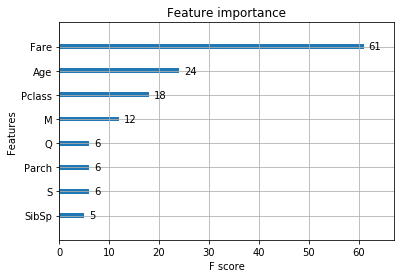

In [481]:
#xgb.plot_importance(bst)

In [0]:
#xgb.to_graphviz(bst, num_trees=2)

#### Predictions

In [0]:
ypred = bst.predict(dtest)

In [484]:
ypred.shape

(418,)

In [0]:
ypred_binary = np.where(ypred > 0.5, 1, 0)
ypred_binary = np.asarray(ypred_binary)

In [0]:
test = pd.read_csv('test.csv')

In [0]:
submission = pd.DataFrame(
    {"PassengerID": test.iloc[:,0],
     "Survived": ypred_binary}
)

In [488]:
submission.head()

,PassengerID,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [0]:
from numpy import asarray
from numpy import savetxt
# save to csv file
savetxt('submission_07.csv', submission, delimiter=',')

In [0]:
submission.to_csv("submission_07.csv", index = False)

### Submit

In [491]:
!kaggle competitions submit -c titanic -f submission_07.csv -m '7 try with xgb'

100% 2.77k/2.77k [00:04<00:00, 706B/s]
Successfully submitted to Titanic: Machine Learning from Disaster

In [492]:
!kaggle competitions submissions -c titanic

fileName           date                 description         status    publicScore  privateScore  
-----------------  -------------------  ------------------  --------  -----------  ------------  
submission_07.csv  2020-03-09 22:12:46  7 try with xgb      complete  0.78947      None          
submission_06.csv  2020-03-09 21:52:21  sixth try with xgb  complete  0.72248      None          
submission_05.csv  2020-03-09 21:13:59  fifth try with xgb  complete  0.72727      None          
submission_04.csv  2020-03-09 20:41:28  forth try with xgb  complete  0.77990      None          
submission_03.csv  2020-03-09 19:53:40  third try with xgb  complete  0.73205      None          
submission_03.csv  2020-03-09 19:53:24  first try with xgb  complete  0.73205      None          
submission_02.csv  2020-03-07 01:35:24  first try with xgb  complete  0.75119      None          
submission_02.csv  2020-03-06 23:37:11  first try with xgb  complete  0.75119      None          
submission_02.csv  2